## Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


from statsmodels.tsa.seasonal import seasonal_decompose



tfk = tf.keras
tfkl = tf.keras.layers
layers=tfkl
print(tf.__version__)


# ----------------------


# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

print('seed:', seed)

2.6.2
seed: 42


## Load Data + EDA

(68528, 7)


 -------------------------- 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


 -------------------------- 




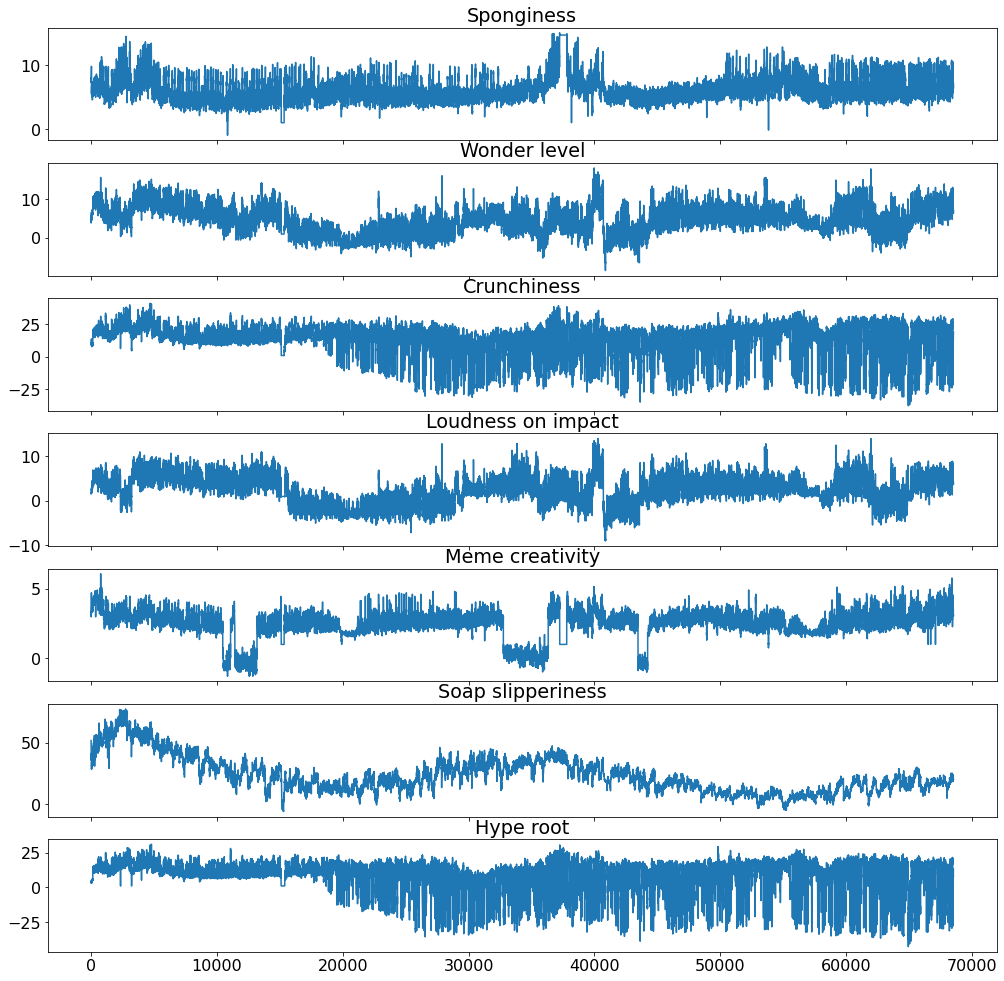

In [2]:
dataset = pd.read_csv('/kaggle/input/timeserie-pasq/Training.csv')
print(dataset.shape)
dataset.head()

print('\n\n -------------------------- \n\n')

dataset.info()

print('\n\n -------------------------- \n\n')

def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

## Sequential Train-Test split

In [3]:
test_ratio = 0.05
test_size = int(dataset.shape[0] * test_ratio)
print(test_size)

X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

3426
(65102, 7) (3426, 7)


## Normalization

In [4]:
# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

## __Parameters__

In [15]:
### TELESCOPE & WINDOW ###

telescope = int(864/2)
window = 3*telescope
stride = int(telescope/16)

print('telescope:\t', telescope) 
print('window:\t\t', window)
print('stride:\t\t', stride)

telescope:	 432
window:		 1296
stride:		 27


## Build Sequences

In [16]:
def build_sequences(df, target_labels=['pollution'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [17]:
target_labels = dataset.columns

X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2384, 1296, 7), (2384, 432, 7), (80, 1296, 7), (80, 432, 7))

## Plots Inspection

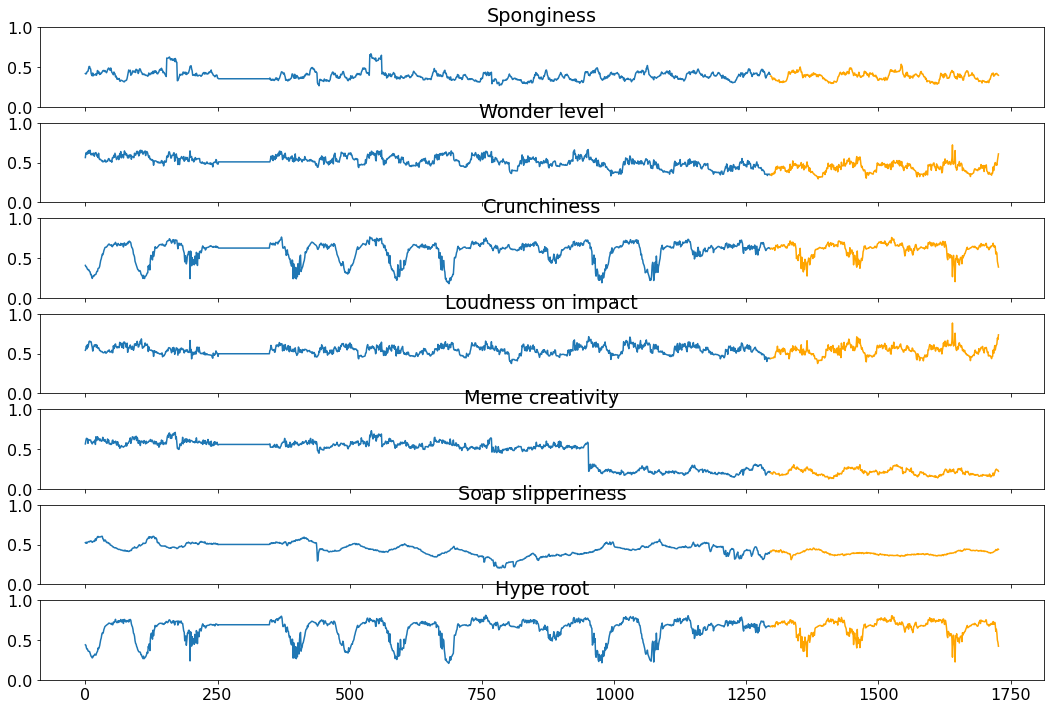

In [18]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(18,12))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()
    
    
inspect_multivariate(X_train, y_train, target_labels, telescope)

## __Model__

In [26]:
input_shape = X_train.shape[1:]
flatten_input = int(input_shape[0]*input_shape[1])

output_shape = y_train.shape[1:]
print(input_shape, flatten_input, output_shape)

units=200
dropout=0.2

ffn_hidden, ffn_output = int(units/2), units

(1296, 7) 9072 (432, 7)


In [27]:
def build_CONV_LSTM_model(input_shape, output_shape):
    
    '''### input ###'''
    inputs = layers.Input(shape=input_shape)
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    
    '''### encoder ###'''
    x = layers.LSTM(units=units, return_sequences=True, dropout=dropout, kernel_initializer=tfk.initializers.GlorotUniform(seed=seed))(x)
#     x = layers.LSTM(units=units, return_sequences=True, dropout=dropout, kernel_initializer=tfk.initializers.GlorotUniform(seed=seed))(x)    
#     x = layers.LSTM(units=units, return_sequences=True, dropout=dropout, kernel_initializer=tfk.initializers.GlorotUniform(seed=seed))(x)    
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    
    '''### attention ###'''
    y = layers.MultiHeadAttention(num_heads=8, key_dim=units, dropout=dropout)(x,x,x)
    y = layers.Add()([x,y])
    y = layers.LayerNormalization(epsilon=1e-6)(y)
    
    y1 = layers.Dense(ffn_hidden, activation='relu')(y)
    y1 = layers.Dense(ffn_output)(y1)
    y1 = layers.Dropout(dropout)(y1)
    y1 = layers.Add()([y1,y])
    y1 = layers.LayerNormalization(epsilon=1e-6)(y1)
    
    w = layers.MultiHeadAttention(num_heads=4, key_dim=units, dropout=dropout)(y1,y1,y1)
    w = layers.Add()([w,y])
    w = layers.LayerNormalization(epsilon=1e-6)(w)
    
    w1 = layers.Dense(ffn_hidden, activation='relu')(w)
    w1 = layers.Dense(ffn_output)(w1)
    w1 = layers.Dropout(dropout)(w1)
    w1 = layers.Add()([w1,w])
    w1 = layers.LayerNormalization(epsilon=1e-6)(w1)
    
    
    mid = w1
    
    
    '''### decoder ###'''
#     x = layers.LSTM(units=units, return_sequences=True, dropout=dropout, kernel_initializer=tfk.initializers.GlorotUniform(seed=seed))(mid)
#     x = layers.LSTM(units=units, return_sequences=True, dropout=dropout, kernel_initializer=tfk.initializers.GlorotUniform(seed=seed))(x)
    x = layers.LSTM(units=units, dropout=dropout, kernel_initializer=tfk.initializers.GlorotUniform(seed=seed))(mid)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    
    '''### output ###'''
#     x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    x = layers.Flatten()(x)
    x = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='elu')(x)
    outputs = tfkl.Reshape((output_shape[-2],output_shape[-1]))(x)

    
    '''### model compilation ###'''
    model = tfk.Model(inputs=inputs, outputs=outputs)
    model.compile(loss=tfk.losses.Huber(), 
                  optimizer=tfk.optimizers.Adam(), 
                  metrics=['mse',
#                            tfk.metrics.RootMeanSquaredError(),
                           'mae'])

    return model

print('ok')

ok


In [28]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.build(input_shape)
model.summary()
# tfk.utils.plot_model(model, expand_nested=True)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1296, 7)]    0                                            
__________________________________________________________________________________________________
layer_normalization_21 (LayerNo (None, 1296, 7)      14          input_4[0][0]                    
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 1296, 200)    166400      layer_normalization_21[0][0]     
__________________________________________________________________________________________________
layer_normalization_22 (LayerNo (None, 1296, 200)    400         lstm_6[0][0]                     
____________________________________________________________________________________________

## Train & Save Best

In [35]:
batch_size = 44
epochs = 250

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=32, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, verbose=1, factor=0.3, min_lr=1e-6)
    ]
).history

Epoch 1/250
49/49 [==============================] - 106s 2s/step - loss: 0.0103 - mse: 0.0206 - mae: 0.1077 - val_loss: 0.0108 - val_mse: 0.0215 - val_mae: 0.1070
Epoch 2/250
49/49 [==============================] - 47s 964ms/step - loss: 0.0101 - mse: 0.0202 - mae: 0.1064 - val_loss: 0.0115 - val_mse: 0.0231 - val_mae: 0.1148
Epoch 3/250
49/49 [==============================] - 47s 965ms/step - loss: 0.0086 - mse: 0.0172 - mae: 0.0990 - val_loss: 0.0105 - val_mse: 0.0211 - val_mae: 0.1050
Epoch 4/250
49/49 [==============================] - 47s 964ms/step - loss: 0.0073 - mse: 0.0145 - mae: 0.0904 - val_loss: 0.0098 - val_mse: 0.0196 - val_mae: 0.1004
Epoch 5/250
49/49 [==============================] - 47s 965ms/step - loss: 0.0063 - mse: 0.0125 - mae: 0.0820 - val_loss: 0.0100 - val_mse: 0.0199 - val_mae: 0.1020
Epoch 6/250
49/49 [==============================] - 47s 965ms/step - loss: 0.0060 - mse: 0.0120 - mae: 0.0802 - val_loss: 0.0095 - val_mse: 0.0190 - val_mae: 0.0988
Epoch 

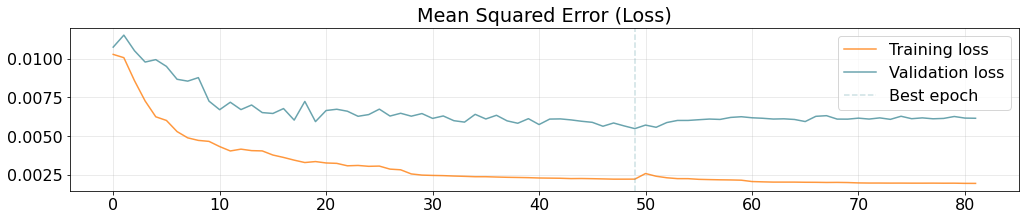

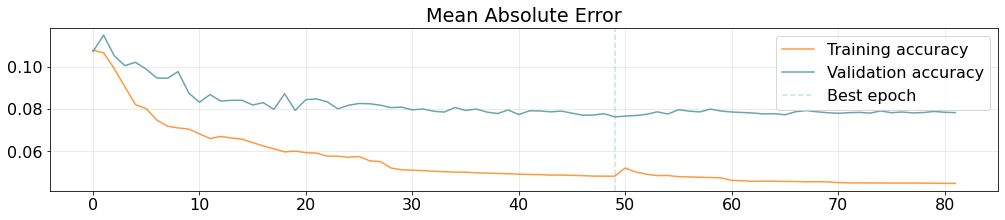

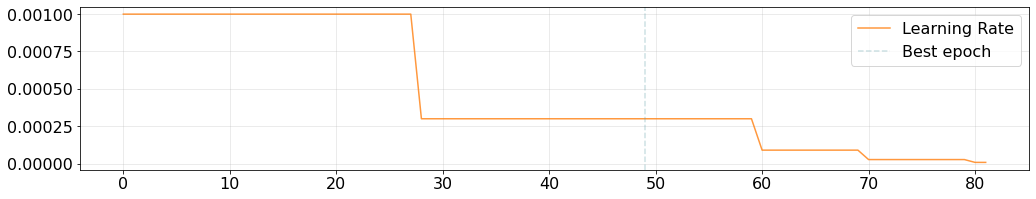

In [36]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,3))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,3))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [37]:
model_dir = '/kaggle/working/models'
model.save(os.path.join(model_dir, 'model'))

2022-01-06 16:40:04.125459: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Test evaluation

In [38]:
### load ###
%cd /kaggle/working/models
model = tfk.models.load_model('model')

/kaggle/working/models


In [39]:
### Predict the test set ### 
print(X_test.shape)
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
print('mse:', mean_squared_error)
print('mae:', mean_absolute_error)

(80, 1296, 7)
(80, 432, 7)
mse: tf.Tensor(0.009167336, shape=(), dtype=float32)
mae: tf.Tensor(0.07206828, shape=(), dtype=float32)


In [55]:
X_test1 = tf.concat((X_test, predictions), axis=1)
print(X_test.shape, predictions.shape, X_test1.shape)

pred1 = model.predict(X_test1)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),pred1.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),pred1.flatten())
print('mse:', mean_squared_error)
print('mae:', mean_absolute_error)

(80, 1296, 7) (80, 432, 7) (80, 1728, 7)


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py:269 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model_3: expected shape=(None, 1296, 7), found shape=(None, 1728, 7)


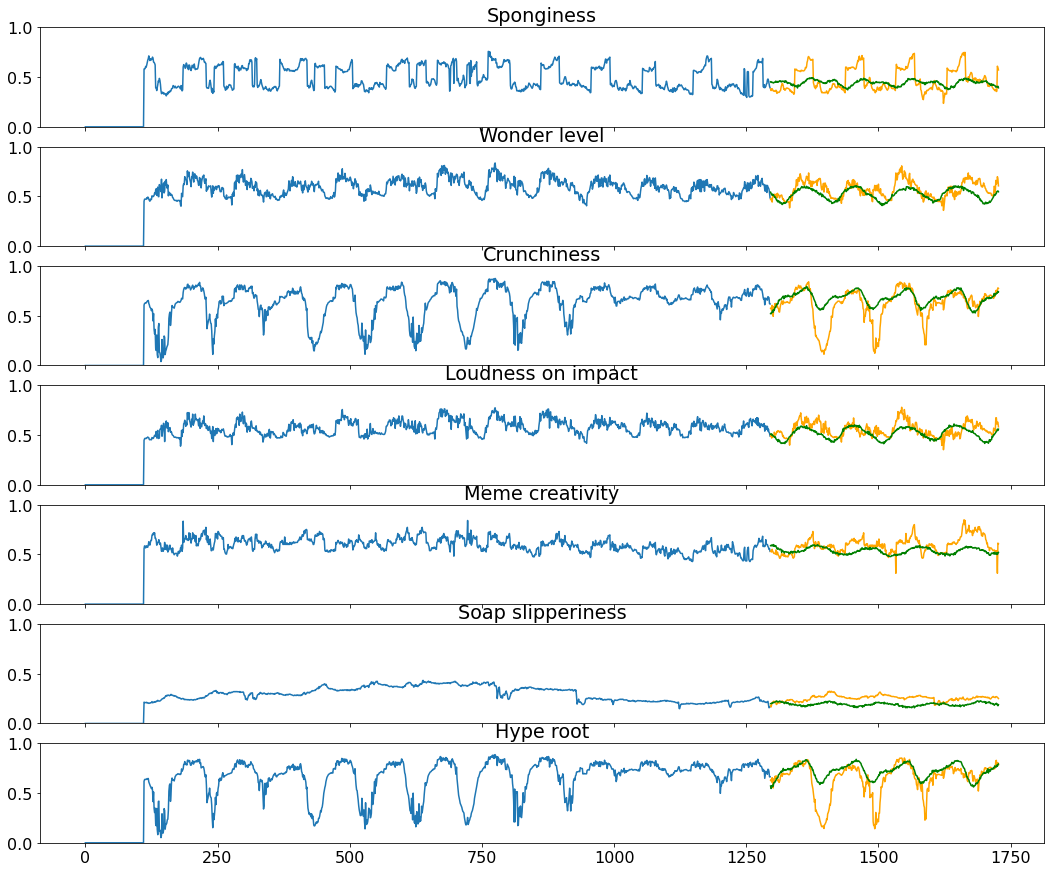

In [40]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(18,15))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()
    
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

## Predict the future 

In [41]:
future = dataset[-window:]     #take last window to predict future telescope
future = (future-X_min)/(X_max-X_min)      #normalize
future = np.expand_dims(future, axis=0)
future.shape

(1, 1296, 7)

In [42]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [43]:
future_predictions = model.predict(future)

### Predicted Plots w/ std-dev

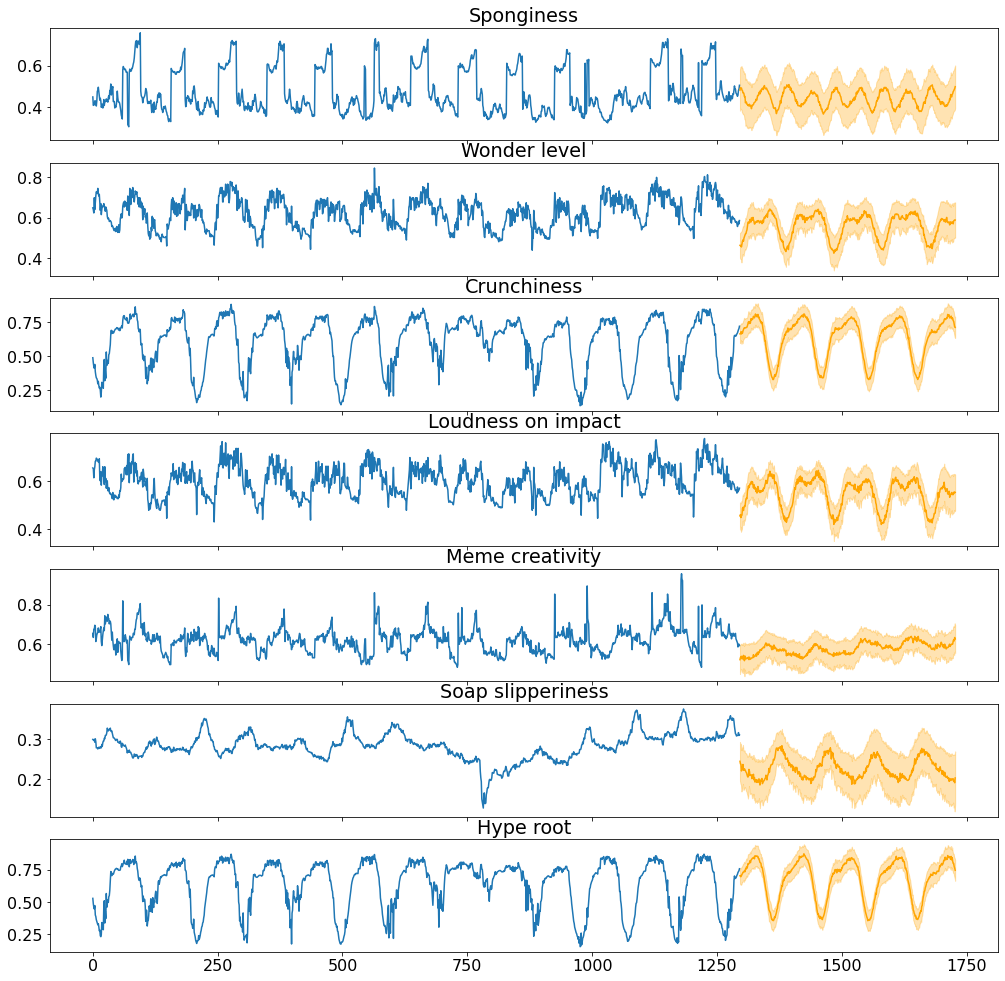

In [44]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), future_predictions[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+telescope), 
        future_predictions[0,:,i]+maes[:,i], 
        future_predictions[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

## zippalo sul server

In [45]:
%cd /kaggle/working/models
!ls model

!ls
!zip -r model.zip model

%mv model.zip /kaggle/working

/kaggle/working/models
assets	keras_metadata.pb  saved_model.pb  variables
model
  adding: model/ (stored 0%)
  adding: model/saved_model.pb (deflated 89%)
  adding: model/keras_metadata.pb (deflated 94%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model/variables/variables.index (deflated 75%)
  adding: model/assets/ (stored 0%)


In [46]:
!ls
%mv ../model.zip ../model2.zip

model
